In [1]:
import numpy as np
from matplotlib import pyplot as plt
from functools import partial

# Данные в задаче

In [2]:
def f(t, x, xp):
    return x*x + t*xp + xp*xp

# x(0) = 0, x(1) = 0.25 - boundary conditions

def f_prime_x(t, x, xp):
    return 2*x

def f_prime_xp(t, x, xp):
    return t + 2*xp

def f_prime_x_x(t, x, xp):
    return 2 + 0*t

def f_prime_x_xp(t, x, xp):
    return 0 + 0*t

def f_prime_xp_xp(t, x, xp):
    return 2 + 0*t

def x_exact(t):
    return 0.5 + (2 - np.e)/4/(np.e*np.e - 1) * np.exp(t) + (np.e - 2*np.e*np.e)/4/(np.e*np.e - 1) * np.exp(-t)

# Построение целевой функции, ее градиента и гессиана

Учитывается, что рассмотривается задача с закрепленными концами без дополнительных условий.

Используется конкретный метод вычисления производных методом конечных разностей (разность значения в правой и текущей точках).

Используется конкретный метод аппроксимации интегрального функционала (метод прямоугольников).

Используется конкретное количество точек разбиения $N = 100$.

In [3]:
def xp_approx_jac_h(N):
    # returns jacobian of def_approx of shape N *(N-1) - contains partial derivatives of xp(x_1, ..., x_N-1)
    
    # approximation of derivatives can be calculated as: xp = 1/h * J * x, xp_0 += -1/h * x_0, xp_N-1 += 1/h * x_N
    # where J is a return of this function 
    
    J = np.zeros((N, N-1))
    idx = np.arange(N-1)
    J[idx, idx] = 1
    J[idx+1, idx] = -1
    
    return J

def J(x, t, x_0, x_f, xp_jac, f):
    # t = (t_0, ..., t_N), x = (x_1, ..., x_N-1)
    # x_0 and x_f - given boundary conditions
    # xp_jac - matrix-jacobian (multiplied by h!) of xp(x_1, ..., x_N-1) of shape N * (N-1)
    # f - given function
    
    N = t.shape[0] - 1 # number of points
    h = t[1] - t[0] # time step
    x_full = np.concatenate(([x_0], x)) # vector (x_0, ..., x_N-1)
    
    xp = xp_jac @ x / h # calculating derivative approximations
    xp[0] += (-1) * x_0 / h
    xp[N-1] += x_f / h    
    
    return np.sum(f(t[:-1], x_full, xp)) * h


def J_grad(x, t, x_0, x_f, xp_jac, f_prime_x, f_prime_xp):
    # t = (t_0, ..., t_N), x = (x_1, ..., x_N-1)
    # x_0 and x_f - given boundary conditions
    # xp_jac - matrix-jacobian (multiplied by h!) of xp(x_1, ..., x_N-1) of shape N * (N-1)
    # f_prime_x, f_prime_xp - partial derivatives of f
    
    N = t.shape[0] - 1 # number of points
    h = t[1] - t[0] # time step
    x_full = np.concatenate(([x_0], x)) # vector (x_0, ..., x_N-1)
    
    xp = xp_jac @ x / h # calculating derivative approximations
    xp[0] += (-1) * x_0 / h
    xp[N-1] += x_f / h    
    
    return h * f_prime_x(t[1:-1], x_full[1:], xp[1:]) + xp_jac.T @ f_prime_xp(t[:-1], x_full, xp)


def J_hessian(x, t, x_0, x_f, xp_jac, f_prime_x_x, f_prime_x_xp, f_prime_xp_xp):
    # t = (t_0, ..., t_N), x = (x_1, ..., x_N-1)
    # x_0 and x_f - given boundary conditions
    # xp_jac - matrix-jacobian (multiplied by h!) of xp(x_1, ..., x_N-1) of shape N * (N-1)
    # f_prime_x_x, f_prime_x_xp, f_prime_xp_xp - second partial derivatives of f 
    
    N = t.shape[0] - 1 # number of points
    h = t[1] - t[0] # time step
    x_full = np.concatenate(([x_0], x)) # vector (x_0, ..., x_N-1)
    
    xp = xp_jac @ x / h # calculating derivative approximations
    xp[0] += (-1) * x_0 / h
    xp[N-1] += x_f / h 
    
    R = np.diag(f_prime_x_xp(t[1:-1], x_full[1:], xp[1:])) @ xp_jac[1:] # auxilliary matrix
    
    return (h * np.diag(f_prime_x_x(t[1:-1], x_full[1:], xp[1:])) + R + R.T +
            xp_jac.T @ np.diag(f_prime_xp_xp(t[:-1], x_full, xp)) @ xp_jac / h)
            


In [114]:
N = 50
ts = np.linspace(0,1,N+1)

J_target = partial(J, t = ts, x_0 = 0, x_f = 0.25, xp_jac = xp_approx_jac_h(N), f = f)
J_target_grad = partial(J_grad, t = ts, x_0 = 0, x_f = 0.25, xp_jac = xp_approx_jac_h(N), 
                        f_prime_x = f_prime_x, f_prime_xp = f_prime_xp)
J_target_hessian = partial(J_hessian, t = ts, x_0 = 0, x_f = 0.25, xp_jac = xp_approx_jac_h(N),
                          f_prime_x_x = f_prime_x_x, f_prime_x_xp = f_prime_x_xp, f_prime_xp_xp = f_prime_xp_xp)

# Whale optimization algorithm

Это именно алгоритм оптимизации функции. Его предположения не связаны с предположениями предыдущего пункта.

In [227]:
def fmin_whale(f, bounds, N_whales, N_iter, b=1, retall=False):
    # f - a function that is being minimized
    # bounds - a tuple ([l_1, u_1], [l_2, u_2], ..., [l_n, u_n]) - a hypercube where we search for a solution
    # N_whale - number of search agents
    # N_iter - number of iterations
    # b - parameter of logarithmic curve
    
    bounds_arr = np.array(bounds)
    n = len(bounds) # dimensionality of a problem
    whales = np.random.uniform(bounds_arr[:,0], bounds_arr[:,1], (N_whales, n)) # initial random agents
    
    scores = np.apply_along_axis(f, 1, whales)
    best = np.copy(whales[np.argmin(scores)])
    #print(np.average(np.abs(x_exact(np.linspace(0,1,N+1))[1:-1] - best)))
    
    iterations = []
    iterations.append((best, f(best)))
    
    for t in range(N_iter):
        a = 2 - 2*t/N_iter 
        old_whales = np.copy(whales)
        
        for i in range(N_whales):
            A = np.random.uniform(-a,a)
            l = np.random.uniform(0,1)
            p = np.random.uniform(0,1)
            
            if p < 0.5 and np.abs(A) <= 1:
                whales[i] = best - A * np.abs(best - whales[i])
            if p < 0.5 and np.abs(A) > 1:
                r = np.random.randint(0,N_whales)
                whales[i] = old_whales[r] - A * np.abs(old_whales[r] - whales[i])
            if p >= 0.5:
                whales[i] = np.abs(best - whales[i]) * np.exp(b*l) * np.cos(2*np.pi*l) + best
                
            # checking feasibility
            feas = np.logical_or(whales[i] < bounds_arr[:,0], whales[i] > bounds_arr[:,1])
            if np.any(feas):
                whales[i] = old_whales[i]
            
        scores = np.apply_along_axis(f, 1, whales)
        best = np.copy(whales[np.argmin(scores)])
        #print(f(best))
        #print(np.average(np.abs(x_exact(np.linspace(0,1,N+1))[1:-1] - best)))
        iterations.append((best, f(best)))
        
    if retall == False:
        return best
    return (best, iterations)

        
# next function is specifically designed for calculus of variations problems

def fmin_whale_special(f, cond, bounds, N_whales, N_iter, b=1, smoothing=1, retall=False):
    # f - a function that is being minimized
    # cond - [x_0, x_N] - boundar conditions for a constrained calculus of variations problem
    # bounds - a tuple ([l_1, u_1], [l_2, u_2], ..., [l_n, u_n]) - a hypercube where we search for a solution
    # N_whale - number of search agents
    # N_iter - number of iterations
    # b - parameter of logarithmic curve
    # smoothing - number of smoothing iterations
    
    bounds_arr = np.array(bounds)
    n = len(bounds) # dimensionality of a problem
    whales = np.random.uniform(bounds_arr[:,0], bounds_arr[:,1], (N_whales, n)) # initial random agents
    
    scores = np.apply_along_axis(f, 1, whales)
    best = np.copy(whales[np.argmin(scores)])
    #print(np.average(np.abs(x_exact(np.linspace(0,1,N+1))[1:-1] - best)))
    
    iterations = []
    iterations.append((best, f(best)))
    
    for t in range(N_iter):
        a = 2 - 2*t/N_iter 
        old_whales = np.copy(whales)
        
        for i in range(N_whales):
            A = np.random.uniform(-a,a)
            l = np.random.uniform(0,1)
            p = np.random.uniform(0,1)
            
            if p < 0.5 and np.abs(A) <= 1:
                whales[i] = best - A * np.abs(best - whales[i])
            if p < 0.5 and np.abs(A) > 1:
                r = np.random.randint(0,N_whales)
                whales[i] = old_whales[r] - A * np.abs(old_whales[r] - whales[i])
            if p >= 0.5:
                whales[i] = np.abs(best - whales[i]) * np.exp(b*l) * np.cos(2*np.pi*l) + best
                
            # checking feasibility
            feas = np.logical_or(whales[i] < bounds_arr[:,0], whales[i] > bounds_arr[:,1])
            if np.any(feas):
                whales[i] = old_whales[i]
            else: # smoothing
                for sm in range(smoothing):
                    mask = ((whales[i] - np.concatenate(([cond[0]], whales[i][:-1]))) * 
                            (np.concatenate((whales[i][1:], [cond[1]])) - whales[i])) < 0
                    whales[i] += mask * ((np.concatenate(([cond[0]], whales[i][:-1])) + 
                                         np.concatenate((whales[i][1:], [cond[1]]))) / 2 - whales[i])
                
            
        scores = np.apply_along_axis(f, 1, whales)
        best = np.copy(whales[np.argmin(scores)])
        #print(f(best))
        #print(np.average(np.abs(x_exact(np.linspace(0,1,N+1))[1:-1] - best)))
        iterations.append((best, f(best)))
        
    if retall == False:
        return best
    return (best, iterations)





## Применение WOA

In [237]:
bounds = tuple([[-10,10]] * (N-1))

'''
x_woa, woa_history = fmin_whale(J_target, bounds, 100, 300, retall = True)
x_woa_full = np.concatenate(([0], x_woa, [0.25]))

woa_errors = [np.average(np.abs(x_exact(ts)[1:-1] - woa_history[i][0])) 
               for i in range(len(woa_history))]
'''


x_woa2, woa2_history = fmin_whale_special(J_target, (0, 0.25), bounds, 300, 500, retall = True)
x_woa2_full = np.concatenate(([0], x_woa2, [0.25]))

woa2_errors = [np.average(np.abs(x_exact(ts)[1:-1] - woa2_history[i][0])) 
               for i in range(len(woa2_history))]

x_woa3, woa3_history = fmin_whale_special(J_target, (0, 0.25), bounds, 300, 500, smoothing = 2, retall = True)
x_woa3_full = np.concatenate(([0], x_woa3, [0.25]))

woa3_errors = [np.average(np.abs(x_exact(ts)[1:-1] - woa3_history[i][0])) 
               for i in range(len(woa3_history))]



#print(np.average(np.abs(x_exact(ts) - x_woa_full)))
#print()


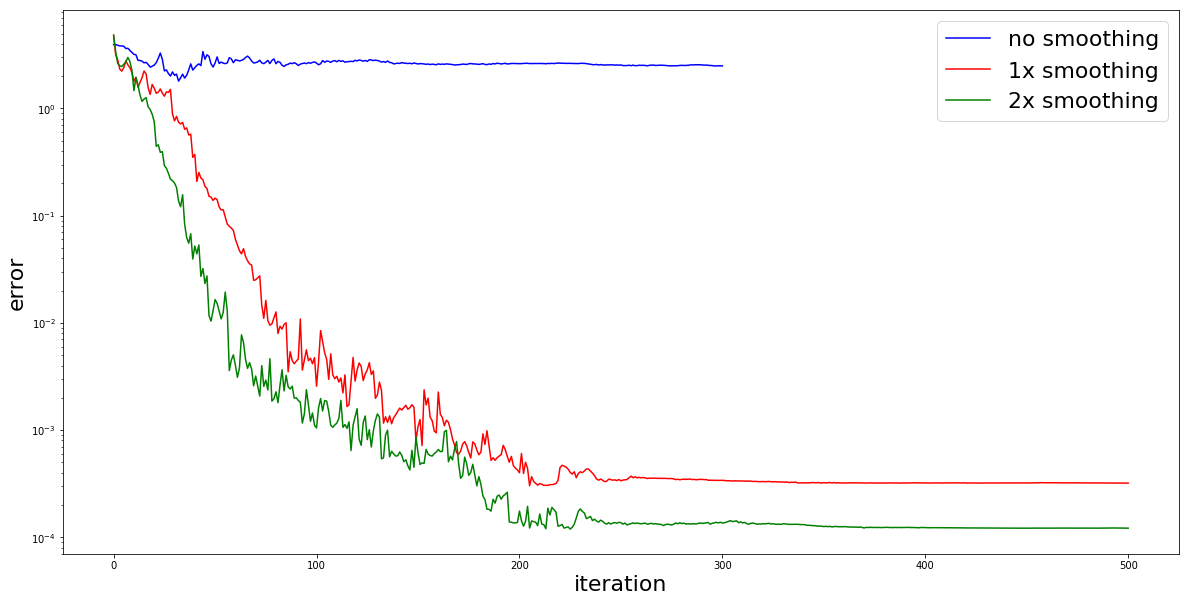

In [238]:
plt.figure(figsize=(20,10))
plt.plot(range(len(woa_errors)), woa_errors, color='blue', label='no smoothing')
plt.plot(range(len(woa2_errors)), woa2_errors, color='red', label='1x smoothing')
plt.plot(range(len(woa3_errors)), woa3_errors, color='green', label='2x smoothing')
plt.xlabel('iteration', fontsize=22)
plt.ylabel('error', fontsize=22)
plt.yscale('log')
plt.legend(fontsize=22)
plt.show()

## Применение алгоритмов BFGS и метода Ньютона

In [239]:
from scipy.optimize import fmin_bfgs
from scipy.optimize import fmin_ncg

x0 = np.zeros((N-1))

x_bfgs, bfgs_history = fmin_bfgs(J_target, x0, J_target_grad, maxiter=200, retall = True)
x_bfgs_full = np.concatenate(([0], x_bfgs, [0.25]))

bfgs_errors = [np.average(np.abs(x_exact(ts) - np.concatenate(([0], bfgs_history[i], [0.25])))) 
               for i in range(len(bfgs_history))]

#print(np.average(x_exact(ts) - x_bfgs_full))
#print()

x_ncg, ncg_history = fmin_ncg(J_target, x0, J_target_grad, fhess=J_target_hessian, maxiter=200, retall=True)
x_ncg_full = np.concatenate(([0], x_ncg, [0.25]))

ncg_errors = [np.average(np.abs(x_exact(ts) - np.concatenate(([0], ncg_history[i], [0.25])))) 
               for i in range(len(ncg_history))]

#print(np.average(x_exact(ts) - x_ncg_full))
#print()

Optimization terminated successfully.
         Current function value: 0.194478
         Iterations: 52
         Function evaluations: 56
         Gradient evaluations: 56
Optimization terminated successfully.
         Current function value: 0.194478
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 20
         Hessian evaluations: 10


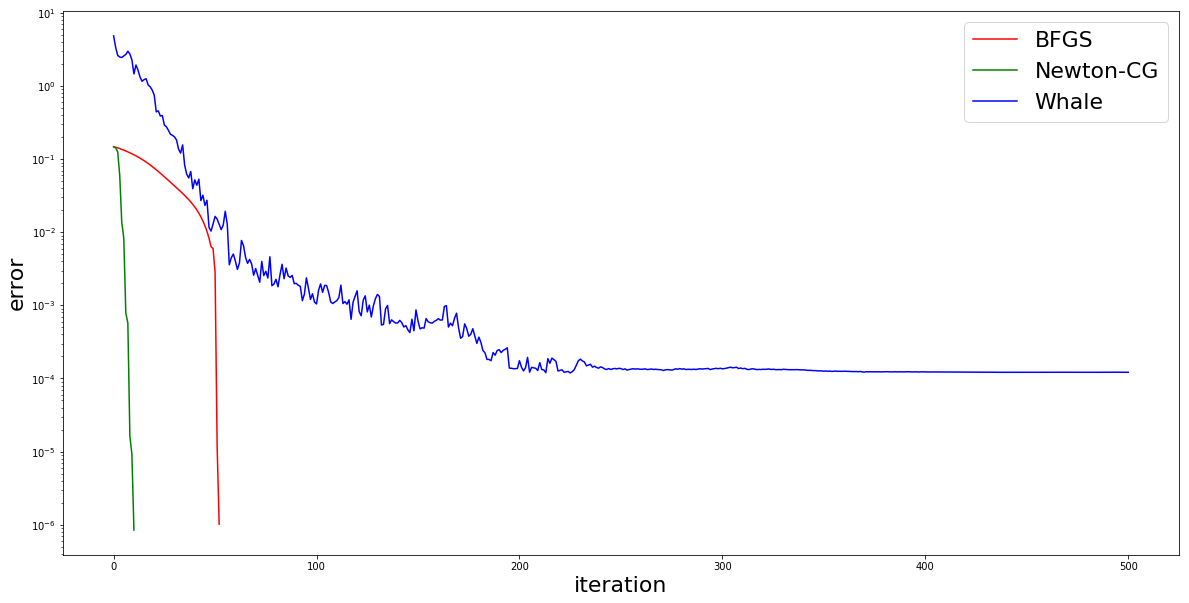

In [240]:
plt.figure(figsize=(20,10))
plt.plot(range(len(bfgs_errors)), bfgs_errors, color='red', label='BFGS')
plt.plot(range(len(ncg_errors)), ncg_errors, color='green', label='Newton-CG')
plt.plot(range(len(woa2_errors)), woa3_errors, color='blue', label='Whale')
plt.xlabel('iteration', fontsize=22)
plt.ylabel('error', fontsize=22)
plt.yscale('log')
plt.legend(fontsize=22)
plt.show()

## Сравнение точного и численного решений

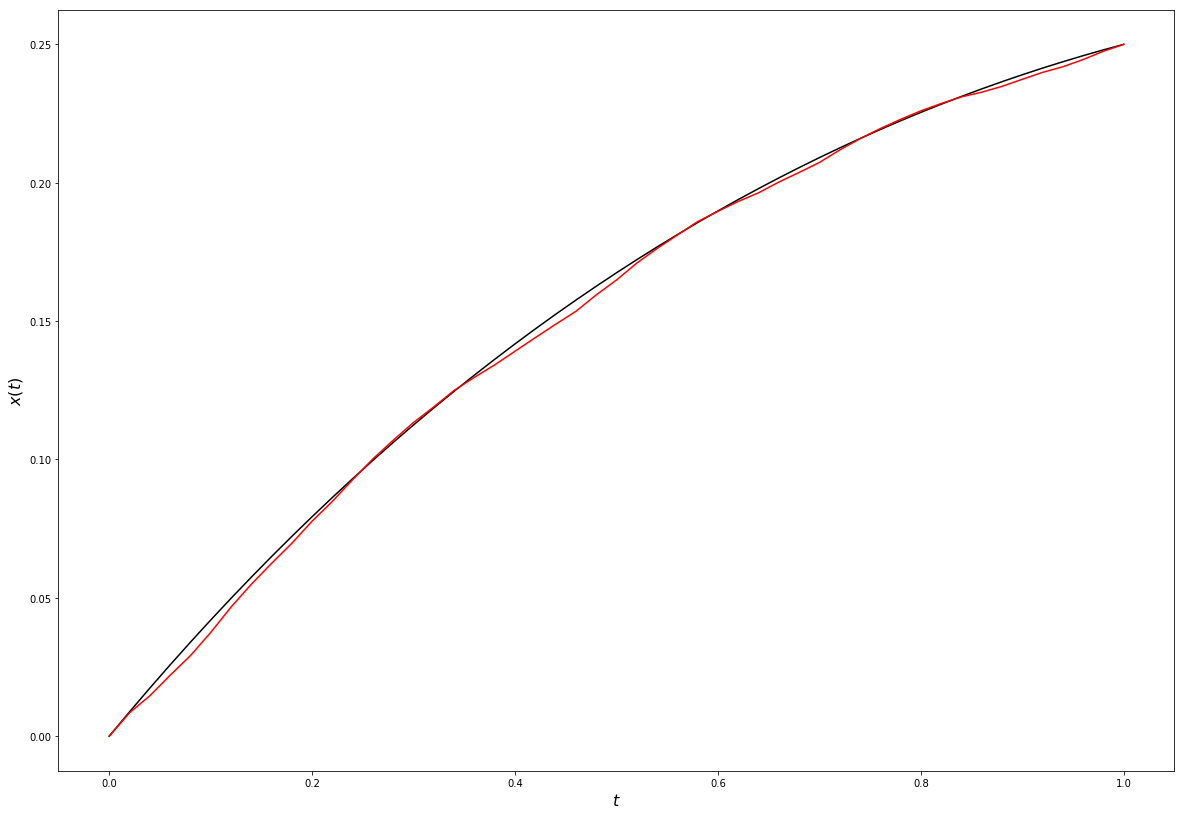

In [236]:
plt.figure(figsize=(20,14))
plt.plot(ts, x_exact(ts), color='black')
plt.plot(ts, x_woa3_full, color='red')
#plt.plot(ts, x_woa3_full, color='green')
plt.xlabel('$t$', fontsize=16)
plt.ylabel('$x(t)$', fontsize=16)
plt.show()